In [35]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import descartes
import re
from datetime import datetime
import calmap
import geopandas
import geoplot
import shapefile as shp
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression, LogisticRegression
from VendorsParsingTools import *
from ForumParsingTools import *
from ProductListingParsingTools import *
from libs.milestone2Methods import *

# Table of content

## 1) General overview 
    1.0) Used datasets  
    1.1) Files obtained for each day  
    1.2) Services Uptime   
    1.3) Unusable files (celles qu'on a pas réussi à utiliser)  

## 2) Forum Analysis  
    2.1) Selected Features and DF  
    2.2.1) Data quality analysis
    2.2.2) Data Enrichment
    2.3) Index Stats Insight
    2.4) Topics Boards Insight

## 3) Market Analysis  
    3.1) Selected Features  
    3.2.1) Data Quality Analysis  
    3.2.2) Data Enrichment (typiquement en utilisant les données de grams)   
    3.3) Vendors Insight  
    3.4) Listings Insight  
   
## 4) Plan multi-variates analysis  
     ....
     
__________________

# 1) General overview

## 1.0) Used datasets

###  [_DN Archives (2013-2015)_](https://www.gwern.net/DNM-archives)

  - ##### Description
  The archive contains mostly scrapped _html_ pages from the many marketplaces, forums and other services (e.g. _Grams_ search engine) that were active during the period mentioned in the title. This raw data is organized first by service, then by date (meaning that for every service, one can go to a specific date and see a list of _html_ pages). Every archive is unambiguous on the format of the platform it represents, standard formatting can then be expected (e.g. item, profile, forum thread, list of items, etc.). However it is expected to be highly incomplete and most likely present inconsistencies.  All the directories are compressed using `tar.gz` compression. The whole archive is about `60 GiB` compressed and estimated to be about `1TiB` completely uncompressed.
  - ##### Data Management and Parsing
  Unshaken by the enormous size of this archive, a large amount of processing work is expected in order to filter out all the _html_ formatting data. Extracted data will most likely be placed into several `Pandas DataFrame` before being processed and prepared for statistical work.
  - ##### Data Enrichment and Processing
  Using online resources like the description of the dataset or tools from provided and found papers. As mentioned in the source description, the incompleteness of the Dataset will require a thorough study of the semantic behind the data as well as the use of adapted tools and methods.

### [_DNStats_](https://dnstats.net/)
  - #### Description
  TODO

## 1.1) Files obtained for each day

In [24]:
agora_df = pd.read_csv('../data/agora_filesnum.out')
forum_df = pd.read_csv('../data/agora-forum_filesnum.out')

In [25]:
all_days_df = generateFileCount(forum_df, agora_df)

In [4]:
events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])

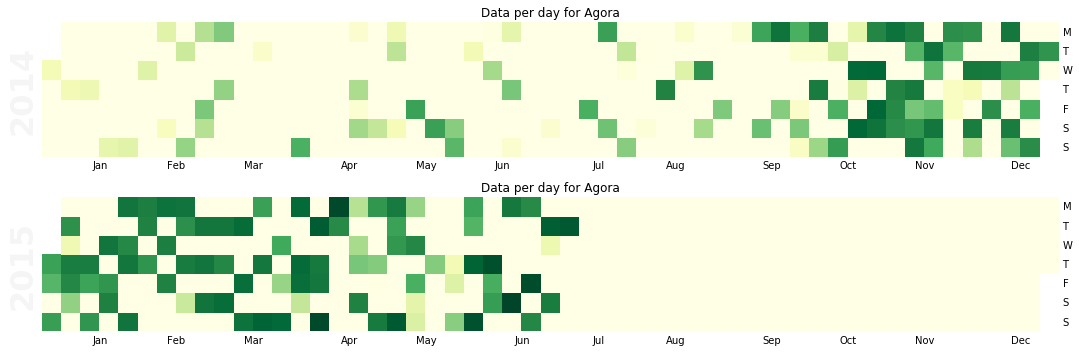

In [6]:
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0, fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora'});

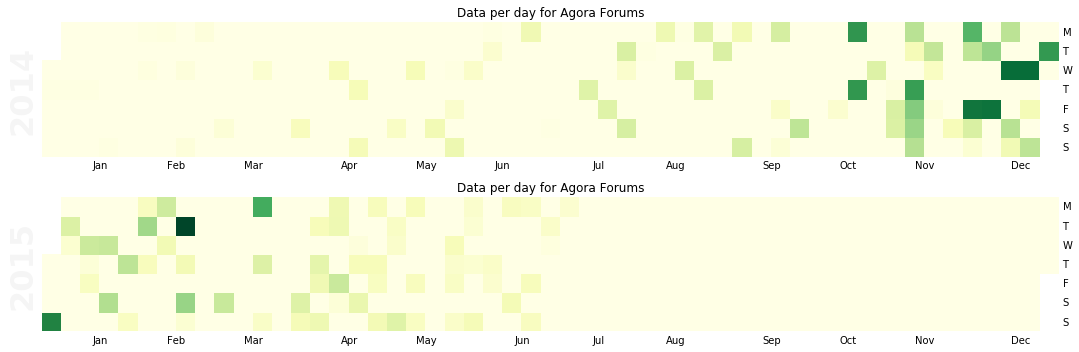

In [7]:
calmap.calendarplot(events_for,daylabels='MTWTFSS',cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0,fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora Forums'});

This calendars map show the amount of data per day we have for Agora and Agora Forum. We clearly have a satisfactory amount of data for the market, but we dont have a reliable amount for the forum.

We then decide to use DNStats which is an up-to-date site tracking darknet markets, products, vendors, news, and more. This way, we can track the amount of available files for each days for Agora.

## 1.2) Services Uptime

In [8]:
agora_df1 = pd.read_csv('../data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

In [9]:
agora_df1

sitename  siteup           timestamp  httpcode
0              Agora       1 2014-04-23 15:04:03       404
1              Agora       1 2014-04-23 15:15:05       404
2              Agora       1 2014-04-23 15:40:17       404
3              Agora       1 2014-04-23 15:45:03       404
4              Agora       1 2014-04-23 16:00:05       404
...              ...     ...                 ...       ...
599388  Agora Forums       1 2017-03-25 22:34:01       503
599389  Agora Forums       1 2017-03-25 22:35:15       503
599390  Agora Forums       1 2017-03-25 22:40:20       503
599391  Agora Forums       1 2017-03-25 22:45:35       503
599392  Agora Forums       1 2017-03-25 22:50:13       503

[599393 rows x 4 columns]

In [10]:
agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)

In [11]:
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

In [12]:
agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
forum_subdf1 = agora_df1[agora_df1['sitename'] == "Agora Forums"]

In [13]:
agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
forum_subdf1 = forum_subdf1.groupby(by='timestamp').mean()

In [14]:
forum_subdf1.groupby(by='timestamp').describe()

siteup                                                        \
            count      mean std       min       25%       50%       75%   
timestamp                                                                 
2014-04-24    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-25    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-26    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-27    1.0  0.989583 NaN  0.989583  0.989583  0.989583  0.989583   
2014-04-28    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
...           ...       ...  ..       ...       ...       ...       ...   
2017-03-22    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-23    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-24    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-25    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-26    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   

                     httpcode                                                  \
                 max    count       mean std        min        25%        50%   
timestamp                                                                       
2014-04-24  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-25  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-26  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-27  0.989583      1.0  203.15625 NaN  203.15625  203.15625  203.15625   
2014-04-28  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
...              ...      ...        ...  ..        ...        ...        ...   
2017-03-22  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-23  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-24  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-25  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-26  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   

                                  
                  75%        max  
timestamp                         
2014-04-24  200.00000  200.00000  
2014-04-25  200.00000  200.00000  
2014-04-26  200.00000  200.00000  
2014-04-27  203.15625  203.15625  
2014-04-28  200.00000  200.00000  
...               ...        ...  
2017-03-22  503.00000  503.00000  
2017-03-23  503.00000  503.00000  
2017-03-24  503.00000  503.00000  
2017-03-25  503.00000  503.00000  
2017-03-26  503.00000  503.00000  

[1053 rows x 16 columns]

/home/flou/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



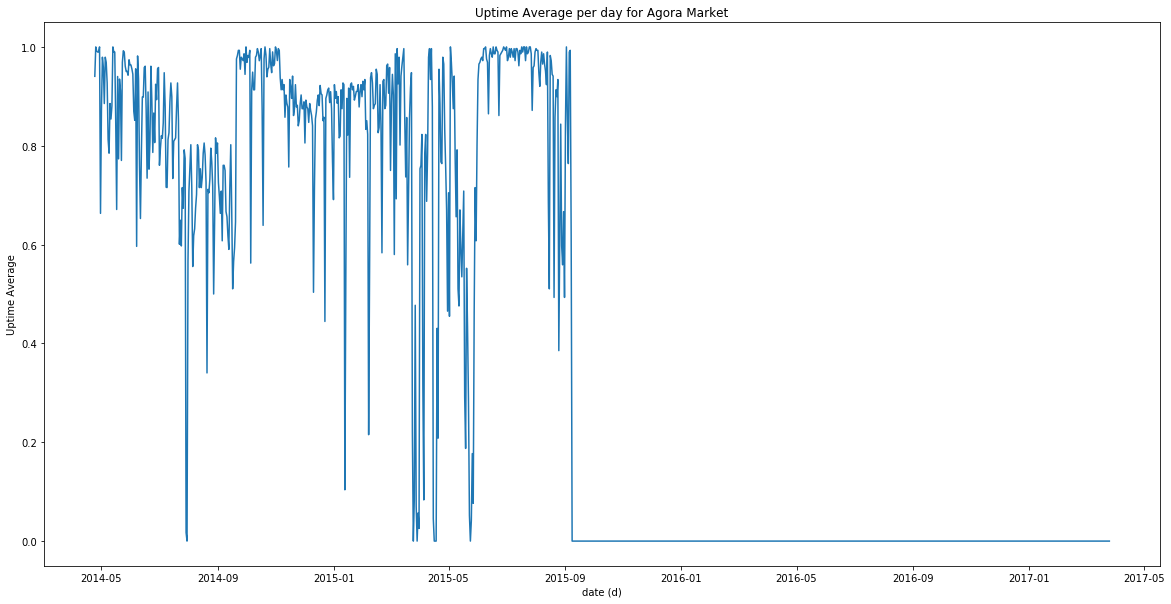

In [15]:
fig, ax1 = plt.subplots( figsize=(20,10))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(agora_subdf1.index, agora_subdf1['siteup'])
ax1.tick_params(axis='y')
plt.title('Uptime Average per day for Agora Market')
plt.show()

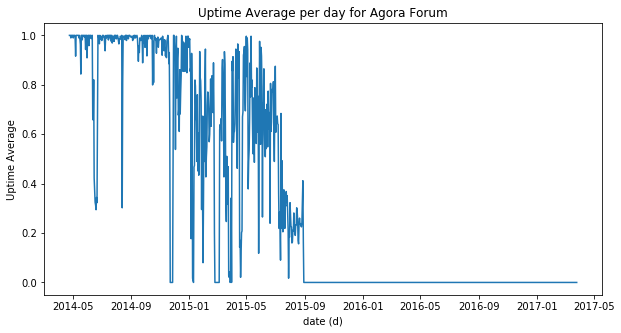

In [16]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(forum_subdf1.index, forum_subdf1['siteup'])
ax1.tick_params(axis='y')
plt.title('Uptime Average per day for Agora Forum')

plt.show()

We observe that the uptime average is very fluctuant over the time for both Agora and Agora Forum.

In [17]:
date_range = pd.date_range(start='2014-11-01', end='2014-12-01', freq='D')

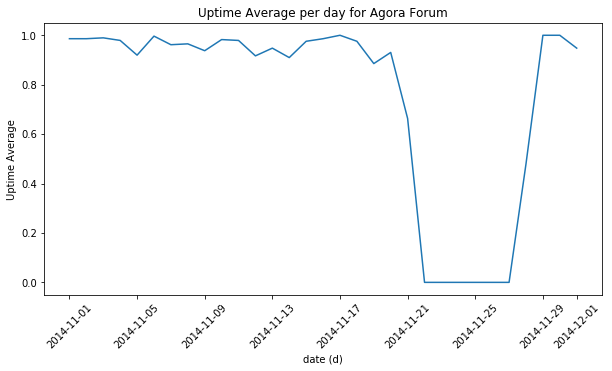

In [18]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(forum_subdf1.loc[date_range].index, forum_subdf1['siteup'][date_range])
ax1.tick_params(axis='y')
plt.xticks(rotation=45);
plt.title('Uptime Average per day for Agora Forum')

plt.show()

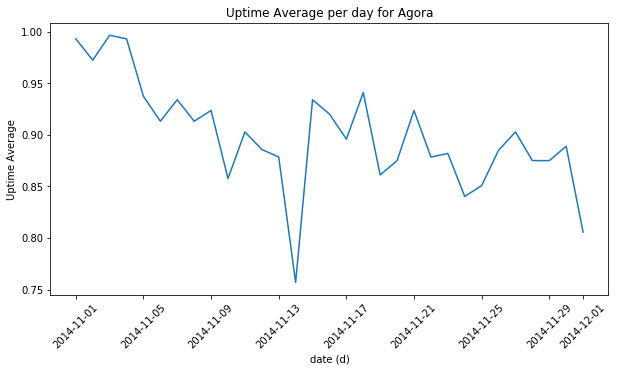

In [19]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(agora_subdf1.loc[date_range].index, agora_subdf1['siteup'][date_range])
ax1.tick_params(axis='y')
plt.xticks(rotation=45);
plt.title('Uptime Average per day for Agora')

plt.show()

Take a look at the period of Operation Onymous and see that there is a fall in the uptime average shortly after both for market and forum, but not at the same time. We also observe that shortly after the drop, the uptime average is back to normal for the forum and it has increased for the market but it tends to slow down.

## 1.3) Unusable Files

_______________________

# 2) Forum Analysis

## 2.1) Selected Features and DF

## 2.2.1) Data quality analysis

In [26]:
nPages_topic_etc_df = pd.read_csv('../saved_gen_df/nPages_nTopicest_nSample_perDayAndBoard.csv')

In [27]:
px.scatter(nPages_topic_etc_df, x='nTopics_est',
           y='nSample', animation_frame='date', animation_group="board",
            
           size='nPages', color="board",range_x=[1,30000], range_y=[1, 10000], log_y=True, log_x=True)

The graph show us the number of samples per board compared to the estimated number of topics per board. The size of the buble gives us the number of pages and the animation give us the graph for each day.

For the Data to be reliable, we need the bubles to be on the x=y axis or above.
Here this is not the case. This is because we only have the first pages for each Topics and hence we miss an important amount of samples.

## 2.2.2) Data Enrichment

## 2.3) Index Stats Insight

In [28]:
directory = "../saved_gen_df/forum_stats_df.csv"
forumDF = pd.read_csv(directory)
forumDF

Unnamed: 0  members     posts  topics  nOnline        date  new_posts  \
0             0      678      1508     317        3  2014-01-02     1508.0   
1             1      822      2198     418        3  2014-01-09      690.0   
2             2     1034      3026     539        3  2014-01-16      828.0   
3             3     1344      5039     757        3  2014-01-26     2013.0   
4             4     1550      6137     895        3  2014-02-03     1098.0   
..          ...      ...       ...     ...      ...         ...        ...   
107         107    56841  16192657   39173        5  2015-06-26   137528.0   
108         108    57227  16417981   60302        5  2015-06-28   225324.0   
109         109    57710  16625015   75172        5  2015-06-30   207034.0   
110         110    57824  16821072   89373        5  2015-07-01   196057.0   
111         111    58005  17128668  108066        5  2015-07-06   307596.0   

     days_elapsed  new_members  new_topics  
0             1.0        678.0       317.0  
1             7.0        144.0       101.0  
2             7.0        212.0       121.0  
3            10.0        310.0       218.0  
4             8.0        206.0       138.0  
..            ...          ...         ...  
107           4.0        188.0       309.0  
108           2.0        386.0     21129.0  
109           2.0        483.0     14870.0  
110           1.0        114.0     14201.0  
111           5.0        181.0     18693.0  

[112 rows x 10 columns]

In [39]:
timedDF = pd.read_csv('../saved_gen_df/forumDF_overTime.csv')
timedDF

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  members     posts  topics  \
0             0             0               0      678      1508     317   
1             1             1               1      822      2198     418   
2             2             2               2     1034      3026     539   
3             3             3               3     1344      5039     757   
4             4             4               4     1550      6137     895   
..          ...           ...             ...      ...       ...     ...   
107         107           107             107    56841  16192657   39173   
108         108           108             108    57227  16417981   60302   
109         109           109             109    57710  16625015   75172   
110         110           110             110    57824  16821072   89373   
111         111           111             111    58005  17128668  108066   

     nOnline        date  new_posts  days_elapsed  new_members  new_topics  
0          3  2014-01-02     1508.0           1.0        678.0       317.0  
1          3  2014-01-09      690.0           7.0        144.0       101.0  
2          3  2014-01-16      828.0           7.0        212.0       121.0  
3          3  2014-01-26     2013.0          10.0        310.0       218.0  
4          3  2014-02-03     1098.0           8.0        206.0       138.0  
..       ...         ...        ...           ...          ...         ...  
107        5  2015-06-26   137528.0           4.0        188.0       309.0  
108        5  2015-06-28   225324.0           2.0        386.0     21129.0  
109        5  2015-06-30   207034.0           2.0        483.0     14870.0  
110        5  2015-07-01   196057.0           1.0        114.0     14201.0  
111        5  2015-07-06   307596.0           5.0        181.0     18693.0  

[112 rows x 12 columns]

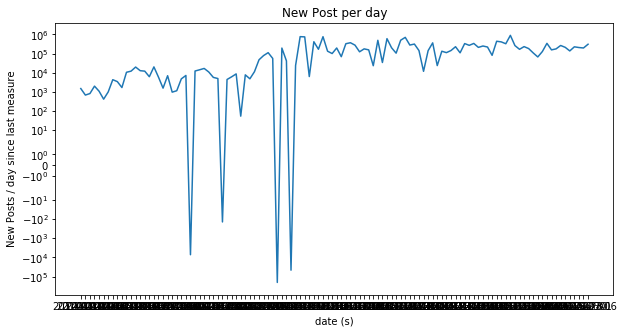

In [53]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Posts / day since last measure')
ax1.plot(forumDF['date'], forumDF['new_posts'])
ax1.tick_params(axis='y')

plt.yscale('symlog')
plt.title('New Post per day')

plt.show()



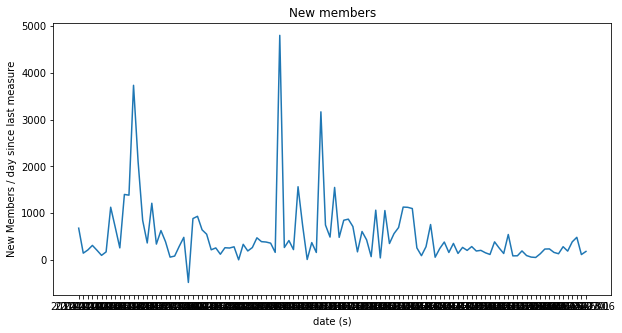

In [32]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Members / day since last measure')
ax1.plot(forumDF['date'], forumDF['new_members'])
ax1.tick_params(axis='y')

plt.title("New members")

plt.show()

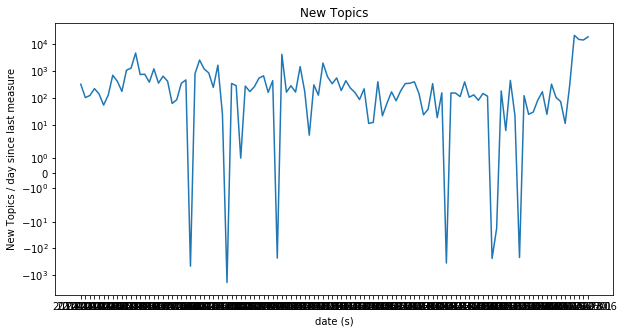

In [33]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Topics / day since last measure')
ax1.plot(forumDF['date'], forumDF['new_topics'])
plt.yscale('symlog')

plt.title('New Topics')

plt.show()

Over this graphs and espetially for the first and third ones, we see that the number of new entries is negative. This means that they have been deleted. Is it related to Onymous operation, or is it just some moderation ?

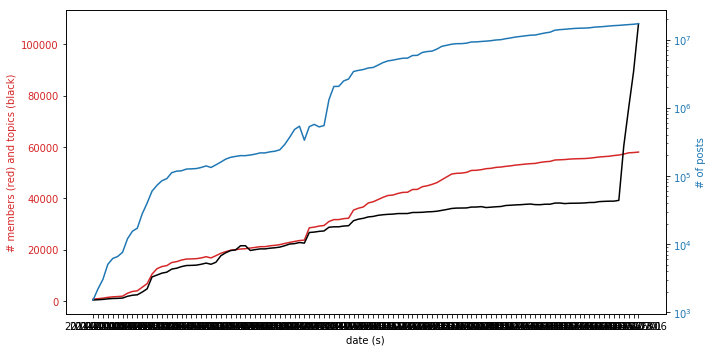

In [64]:
# Plot the number of members (red), of topics (black) and of posts (blue) over time
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('date (s)')
ax1.set_ylabel('# members (red) and topics (black)', color=color)
ax1.plot(forumDF['date'], forumDF['members'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(forumDF['date'], forumDF['topics'], color='black')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# of posts', color=color)  # we already handled the x-label with ax1
ax2.plot(forumDF['date'], forumDF['posts'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yscale('log')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [76]:
forumDF[forumDF['new_posts'] < 0]
# SHw that posts were removed on those particular days

Unnamed: 0  members   posts  topics  nOnline        date  new_posts  \
24          24    16716  132894   14246        5  2014-06-10    -7243.0   
31          31    20317  198093   21485        5  2014-08-02     -142.0   
43          43    23664  334265   22495        5  2014-09-28  -201673.0   
46          46    29143  523840   27080        5  2014-11-21   -46268.0   

    days_elapsed  new_members  new_topics  
24           1.0       -482.0      -460.0  
31           3.0        121.0        24.0  
43           2.0        161.0      -229.0  
46           2.0        414.0       279.0

In [73]:
forumDF[forumDF['new_members'] < 0]
# Show that members were removed this days precisely

Unnamed: 0  members   posts  topics  nOnline        date  new_posts  \
24          24    16716  132894   14246        5  2014-06-10    -7243.0   

    days_elapsed  new_members  new_topics  
24           1.0       -482.0      -460.0

In [74]:
forumDF[forumDF['new_topics'] < 0]
# Show that topics were removed on those particular days

Unnamed: 0  members     posts  topics  nOnline        date  new_posts  \
24          24    16716    132894   14246        5  2014-06-10    -7243.0   
32          32    20577    202565   19623        5  2014-08-05     4472.0   
43          43    23664    334265   22495        5  2014-09-28  -201673.0   
80          80    51523   9510546   36372        5  2015-04-14   112282.0   
90          90    53589  11693038   37503        5  2015-05-10    81219.0   
91          91    53975  12132780   37485        5  2015-05-11   439742.0   
96          96    55084  14186943   37915        5  2015-05-29   167278.0   

    days_elapsed  new_members  new_topics  
24           1.0       -482.0      -460.0  
32           3.0        260.0     -1862.0  
43           2.0        161.0      -229.0  
80           1.0        382.0      -352.0  
90           4.0        116.0      -237.0  
91           1.0        386.0       -18.0  
96           1.0         88.0      -219.0

In [75]:
forumDF.sort_values(by=('date'))[40:50]
# Show values around the Onymous event

Unnamed: 0  members    posts  topics  nOnline        date  new_posts  \
40          40    22763   368152   22135        5  2014-09-14    78984.0   
41          41    23145   479990   22293        5  2014-09-22   111838.0   
42          42    23503   535938   22724        5  2014-09-26    55948.0   
43          43    23664   334265   22495        5  2014-09-28  -201673.0   
44          44    28464   528328   26640        5  2014-11-18   194063.0   
45          45    28729   570108   26801        5  2014-11-19    41780.0   
46          46    29143   523840   27080        5  2014-11-21   -46268.0   
47          47    29363   547801   27242        5  2014-11-29    23961.0   
48          48    30927  1311793   28683        5  2014-12-15   763992.0   
49          49    31664  2054851   28856        5  2014-12-20   743058.0   

    days_elapsed  new_members  new_topics  
40           6.0        390.0       654.0  
41           8.0        382.0       158.0  
42           4.0        358.0       431.0  
43           2.0        161.0      -229.0  
44          51.0       4800.0      4145.0  
45           1.0        265.0       161.0  
46           2.0        414.0       279.0  
47           8.0        220.0       162.0  
48          16.0       1564.0      1441.0  
49           5.0        737.0       173.0

## 2.4) Topics Boards Insight

____________________________

# 3) Market Analysis

## 3.1) Selected Features  


We extracted several dataframes about the market from the given files, and various sources. 

The vendors dataframe (parsed from html files) has the following features:  
* name: The name of the vendor. It will be used to track vendors through time.
* rating: The rating of the vendor. Probably not usefull in our study
* lastSeen: Is the time (in hours) since the last connection of the vendor.
* publicKey: The publicKey of the vendor.
* #products: The number of products currently sold by the vendor.
* #deals: The number of deals done by the vendor so far.
* parsingDate: The date of the parsing for this entry.


## 3.2.1) Data Quality Analysis 

## 3.2.2) Data Enrichment

In [45]:
price_df = pd.read_csv('../saved_gen_df/prices_and_stuff.csv')
price_df = price_df.drop(columns=['mean', 'std', 'min', '25%', '75%'])

In [46]:
# Get world mat
world = geopandas.read_file(
    geoplot.datasets.get_path('world')
)
sf = shp.Reader('../data/ne_50m_admin_0_countries.shp')
world_df = read_shapefile(sf)

In [47]:
world_df = world_df[['NAME', 'CONTINENT']]
world_df.rename(columns={'NAME':'name'}, inplace=True)
world_df = pd.merge(world, world_df, how='inner')

In [48]:
world_df['count'] = 0
world_df['continent_count'] = 0

In [49]:
DATE = "2015-07-12"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

In [50]:
world_df.to_csv("../saved_gen_df/listing_count_"+DATE+"_map_df.csv")

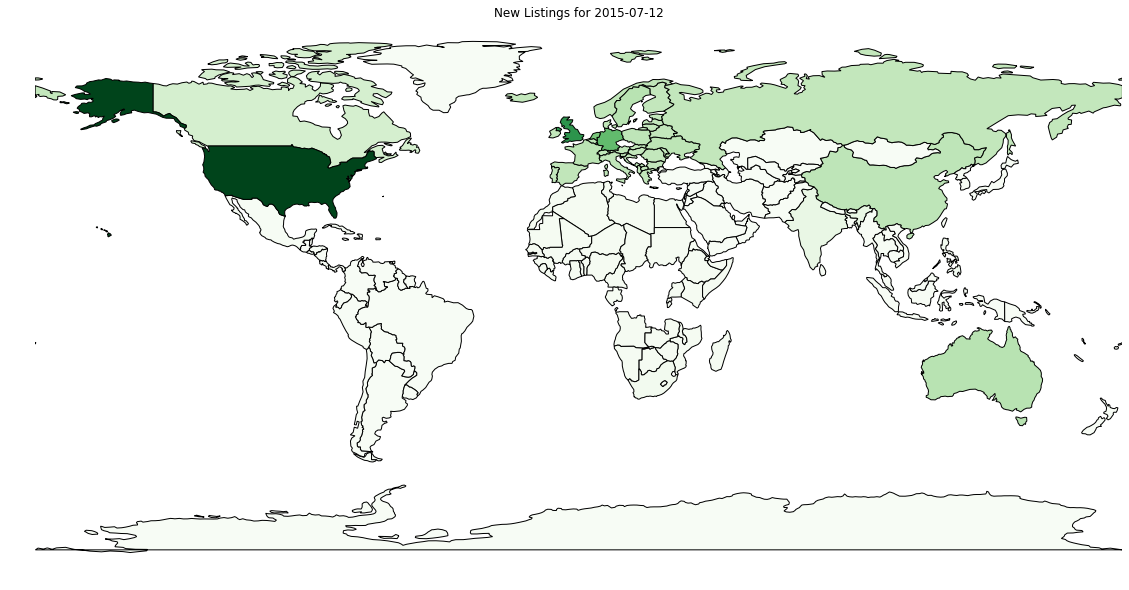

In [55]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));
plt.title('New Listings for 2015-07-12');

In [16]:
DATE = "2014-06-09"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

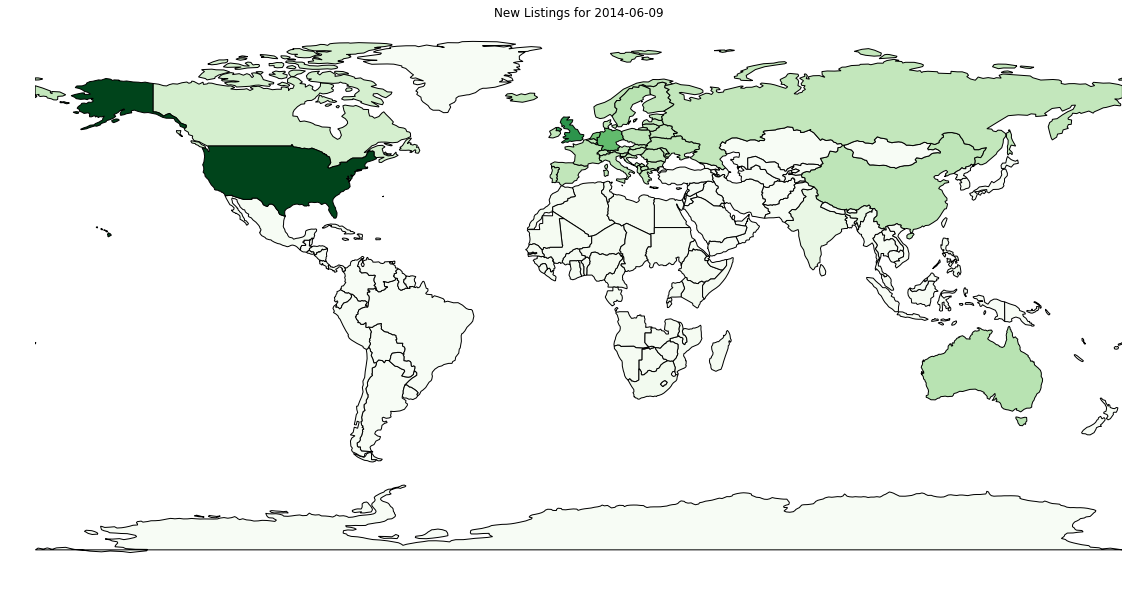

In [56]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));
plt.title('New Listings for 2014-06-09');

The maps looks the same even if they are before and after the Onymous operation.
Is it because the operation did not affect the market, or is this beacause we lack some data ?

## 3.3) Vendors Insight

In [73]:
directory = "../data/agora/2014-04-06/vendor"
vendors = createVendorsDF(directory)

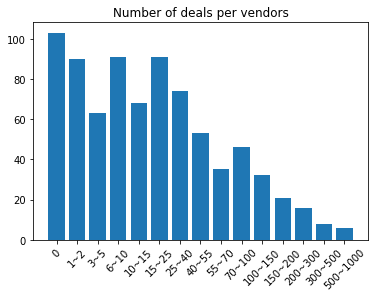

In [74]:
sortedStats = createStatsAboutNumbOfDeals(Counter(vendors['#Deals']))
plt.bar(sortedStats.keys(),sortedStats.values());
plt.xticks(rotation=45);
plt.title('Number of deals per vendors');

Show the repartition of number of deals per vendors. Might be interesting to study the biggest vendors on the plateform, espetially before and after Onymous operation.

In [63]:
cleanVendorsDF = pd.read_csv('../scripts/cleanVendorsDF.csv', index_col = 0)
cleanVendorsDF

name  rating lastSeen publicKey  #products   #Deals  \
0         littlegoblin    4.92        4       NaN       14.0  150~200   
1       Rebel_Alliance    4.99        1       NaN        7.0  300~500   
2        ThePartyDepot    5.00       16       NaN        3.0   70~100   
3             cossacks    4.99        5       NaN        7.0  300~500   
4           checkpoint    4.84       24       NaN       31.0    55~70   
...                ...     ...      ...       ...        ...      ...   
121153       BabyBando    5.00        3       NaN        6.0    10~15   
121154    daydreamer33    4.94       24       NaN        6.0  200~300   
121155      Leckermann    5.00     4176       NaN        8.0      3~5   
121156      EasyRiders     NaN      NaN       NaN        5.0        0   
121157   INSTAGRAMS-UK    4.55       96       NaN        7.0    10~15   

       parsingDate  
0       2014-09-20  
1       2014-09-20  
2       2014-09-20  
3       2014-09-20  
4       2014-09-20  
...            ...  
121153  2014-10-14  
121154  2014-10-14  
121155  2014-10-14  
121156  2014-10-14  
121157  2014-10-14  

[121158 rows x 7 columns]

The number of deals could source of intersting data, since it could reveal the ratio of 'new sellers'

In [67]:
nbVendorbyDate = cleanVendorsDF[['parsingDate', 'name']].groupby(['parsingDate']).agg([ 'count'])
nbVendorbyDate = nbVendorbyDate.sort_values(by='parsingDate')

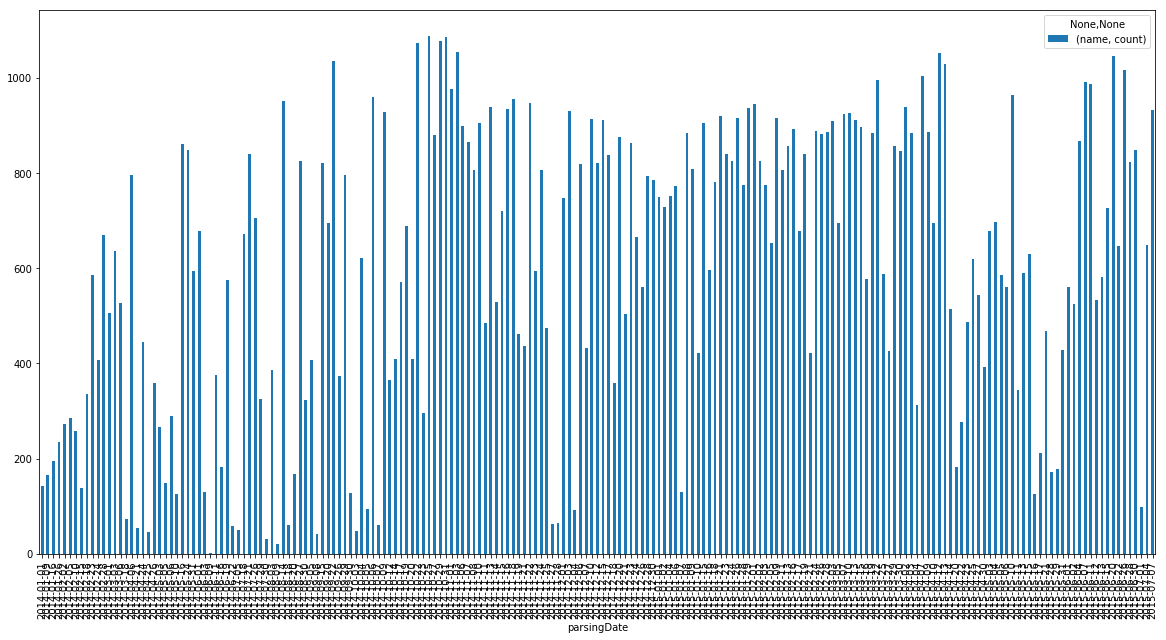

In [66]:
nbVendorbyDate.plot.bar(figsize=(20,10));

We get a plot unusable in the state. There is no visible trend, the data is very noisy. However we might be able to extract some data by watching the first appearance of each pseudo.

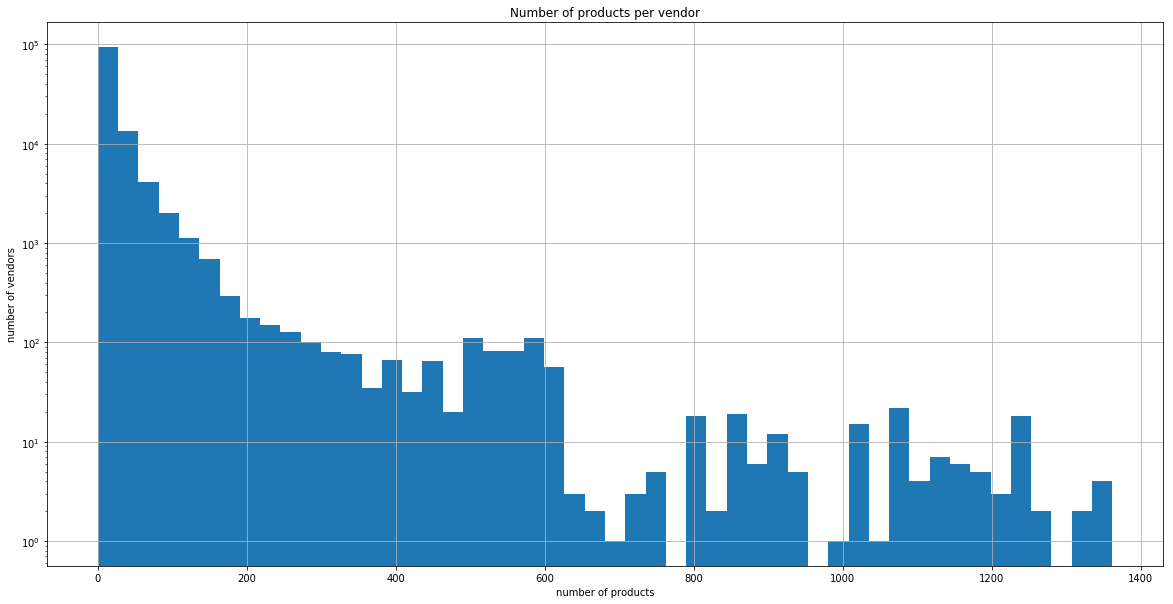

In [71]:
cleanVendorsDF.hist(column='#products',log=True,figsize=(20,10), bins=50)
plt.title('Number of products per vendor')
plt.xlabel('number of products')
plt.ylabel('number of vendors')
plt.show()

This plot shows the huge variation inn the number of products sold by vendors. That means it could be interesting to track the biggest selleres through time since they seam well established.

## 3.4) Listing insight

In [ ]:
# example for synthetic pages
directory = "../data/agora/2014-04-06/cat/arXCLhtVhq/"
productsDF = directoryToDF(directory)
productsDF.head(10)

In [ ]:
country = productsDF['from'].unique()
country

_____________________________________

# 4) Plan multi-variates analysis  